Method: real_8020
  Mean R²: 0.6479
  95% CI: [0.6422, 0.6536]
  Low-freq (<1%) Mean R²: 0.2966
  Low-freq (<1%) 95% CI: [0.2847, 0.3085]
  Rare (<0.1%) Mean R²: 0.0882
  Rare (<0.1%) 95% CI: [0.0775, 0.0988]
Method: pc_real_8020
  Mean R²: 0.5925
  95% CI: [0.5877, 0.5974]
  Low-freq (<1%) Mean R²: 0.2176
  Low-freq (<1%) 95% CI: [0.2077, 0.2275]
  Rare (<0.1%) Mean R²: 0.0526
  Rare (<0.1%) 95% CI: [0.0442, 0.0610]
Method: rbm_full
  Mean R²: 0.5088
  95% CI: [0.5049, 0.5127]
  Low-freq (<1%) Mean R²: 0.0951
  Low-freq (<1%) 95% CI: [0.0873, 0.1030]
  Rare (<0.1%) Mean R²: 0.0119
  Rare (<0.1%) 95% CI: [0.0073, 0.0165]
Method: wgan_full
  Mean R²: 0.4275
  95% CI: [0.4256, 0.4294]
  Low-freq (<1%) Mean R²: 0.0042
  Low-freq (<1%) 95% CI: [0.0035, 0.0050]
  Rare (<0.1%) Mean R²: 0.0001
  Rare (<0.1%) 95% CI: [0.0000, 0.0002]
Method: rbm_8020
  Mean R²: 0.4929
  95% CI: [0.4902, 0.4955]
  Low-freq (<1%) Mean R²: 0.0655
  Low-freq (<1%) 95% CI: [0.0594, 0.0716]
  Rare (<0.1%) Mean R²: 0

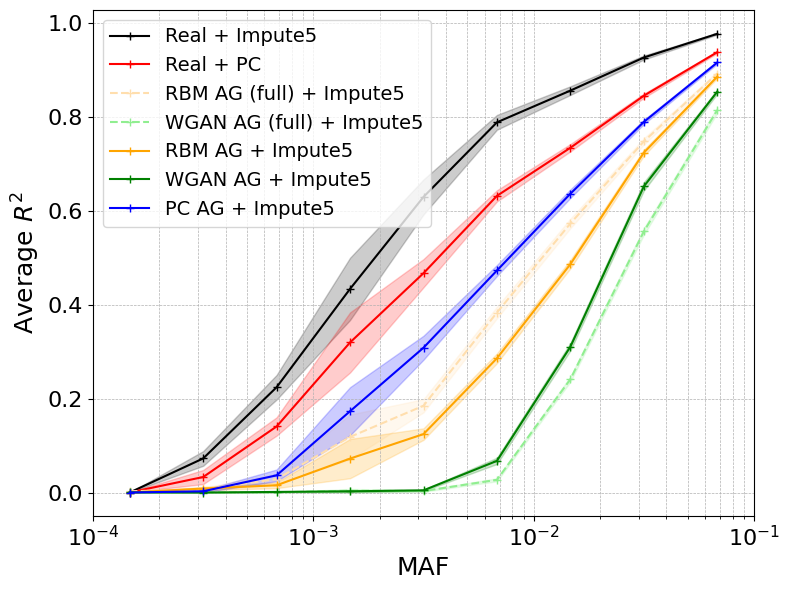

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the logarithmic bins
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Calculate bin centers for plotting

# Plot settings
plt.figure(figsize=(8, 6))

# Methods, colors, markers, labels, and linestyles
all_methods = ['real_8020', 'pc_real_8020', 'rbm_full', 'wgan_full', 'rbm_8020', 'wgan_8020', 'hclt_8020']
all_colors = ['black', 'r', 'navajowhite', 'lightgreen', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+', '+', '+']
all_labels = [
    'Real + Impute5', 'Real + PC', 'RBM AG (full) + Impute5', 'WGAN AG (full) + Impute5',
    'RBM AG + Impute5', 'WGAN AG + Impute5', 'PC AG + Impute5'
]
all_linestyles = ['-', '-', '--', '--', '-', '-', '-']

# Load data
method_data = {method: pd.read_csv(f'results/r2/{method}_8020.csv') for method in all_methods}

for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_8020.csv')
    
    # Get bootstrap columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Define MAF filters
    low_freq = df[df['MAF'] < 0.01]
    rare = df[df['MAF'] < 0.001]

    def summarize_bootstrap(subset_df, label):
        if subset_df.empty:
            print(f"  {label}: No data")
            return

        # Mean of each bootstrap (across SNPs in the filtered group)
        bootstrap_means = subset_df[boot_cols].mean(skipna=True)

        # Mean of the means
        overall_mean = bootstrap_means.mean()
        sem = bootstrap_means.std(ddof=1)
        ci_lower = overall_mean - 1.96 * sem
        ci_upper = overall_mean + 1.96 * sem

        print(f"  {label} Mean R²: {overall_mean:.4f}")
        print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

    print(f"Method: {method}")

    # Full set
    full_bootstrap_means = df[boot_cols].mean(skipna=True)
    full_mean = full_bootstrap_means.mean()
    full_sem = full_bootstrap_means.std(ddof=1)
    full_ci_lower = full_mean - 1.96 * full_sem
    full_ci_upper = full_mean + 1.96 * full_sem
    print(f"  Mean R²: {full_mean:.4f}")
    print(f"  95% CI: [{full_ci_lower:.4f}, {full_ci_upper:.4f}]")

    # Subsets
    summarize_bootstrap(low_freq, "Low-freq (<1%)")
    summarize_bootstrap(rare, "Rare (<0.1%)")

    method_data[method] = df

# Plot each method with CI bands
for method_name, color, marker, label, linestyle in zip(all_methods, all_colors, all_markers, all_labels, all_linestyles):
    df = method_data[method_name]
    
    # Ensure MAF is valid
    df = df[df['MAF'] > 0]
    
    # Digitize MAFs into bins
    bin_indices = np.digitize(df['MAF'], bins) - 1

    # Get the list of bootstrap R2 columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Prepare containers
    mean_r2 = []
    ci_low = []
    ci_high = []

    # Compute stats for each bin
    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values  # shape: (n_snps, 10)
        bin_means = np.nanmean(boot_values, axis=0)     # mean for each bootstrap
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem  # 95% confidence interval

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    # Plot line and confidence interval
    plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

# Plot formatting
plt.xscale('log')
plt.xticks([1e-4, 1e-3, 1e-2, 1e-1],
           [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"],
           fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('MAF', fontsize=18)
plt.ylabel(r'Average $R^2$', fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("results/plots/8020_bootstrap_ci.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()


Method: real_noneur
  Mean R²: 0.4841
  95% CI: [0.4814, 0.4868]
  Low-freq (<1%) Mean R²: 0.1061
  Low-freq (<1%) 95% CI: [0.1002, 0.1119]
  Rare (<0.1%) Mean R²: 0.0204
  Rare (<0.1%) 95% CI: [0.0156, 0.0251]
Method: pc_real_noneur
  Mean R²: 0.5618
  95% CI: [0.5600, 0.5636]
  Low-freq (<1%) Mean R²: 0.1579
  Low-freq (<1%) 95% CI: [0.1552, 0.1607]
  Rare (<0.1%) Mean R²: 0.0207
  Rare (<0.1%) 95% CI: [0.0158, 0.0256]
Method: pc_realeur_and_noneur_train_noneur
  Mean R²: 0.5693
  95% CI: [0.5667, 0.5720]
  Low-freq (<1%) Mean R²: 0.1729
  Low-freq (<1%) 95% CI: [0.1682, 0.1776]
  Rare (<0.1%) Mean R²: 0.0303
  Rare (<0.1%) 95% CI: [0.0246, 0.0360]
Method: rbm_noneur
  Mean R²: 0.4753
  95% CI: [0.4734, 0.4771]
  Low-freq (<1%) Mean R²: 0.0421
  Low-freq (<1%) 95% CI: [0.0390, 0.0453]
  Rare (<0.1%) Mean R²: 0.0028
  Rare (<0.1%) 95% CI: [0.0013, 0.0042]
Method: wgan_noneur
  Mean R²: 0.4216
  95% CI: [0.4203, 0.4230]
  Low-freq (<1%) Mean R²: 0.0032
  Low-freq (<1%) 95% CI: [0.0023,

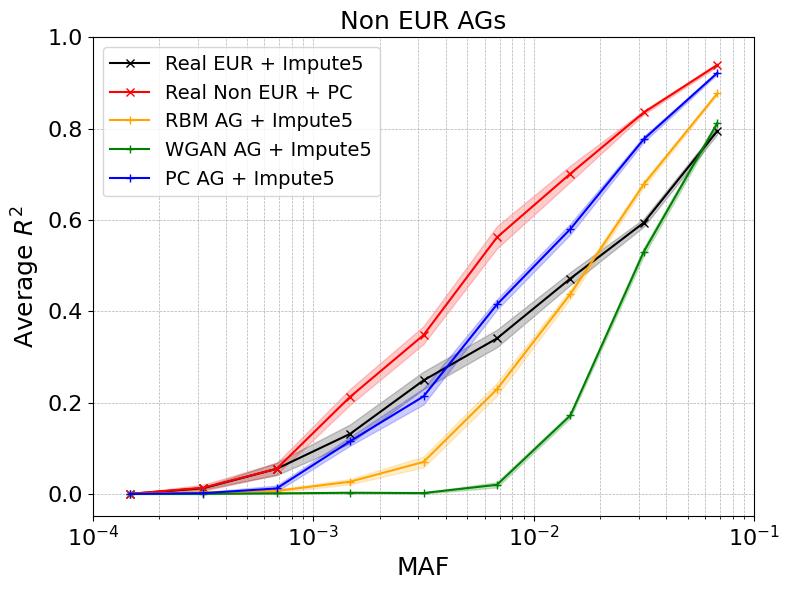

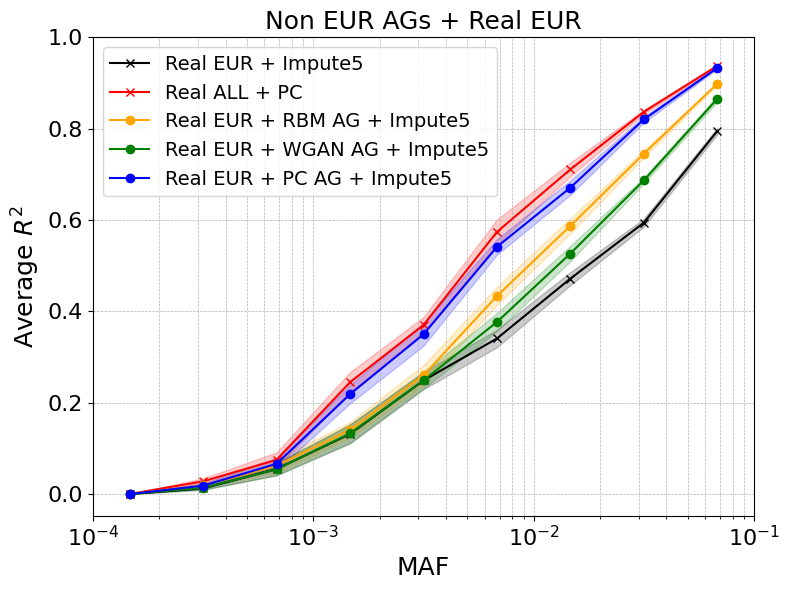

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the logarithmic bins
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Calculate bin centers for plotting

# Methods, colors, markers, and labels
all_methods = ['real_noneur', 'pc_real_noneur', 'pc_realeur_and_noneur_train_noneur', 'rbm_noneur', 'wgan_noneur', 'hclt_noneur', 'rbm_noneur_combined', 'wgan_noneur_combined', 'hclt_noneur_combined']
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = ['Real EUR + Impute5', 'Real Non EUR + PC', 'Real ALL + PC', 'RBM AG + Impute5', 'WGAN AG + Impute5', 'PC AG + Impute5',
              'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', 'Real EUR + PC AG + Impute5']
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

# Split indices for subplotting
baseline_indices = [0, 1, 3, 4, 5]  # RBM, WGAN, HCLT
combined_indices = [0, 2, 6, 7, 8]  # Real EUR + combinations

# Load data
method_data = {method: pd.read_csv(f'results/r2/{method}_noneur.csv') for method in all_methods}

for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_noneur.csv')

    # Get bootstrap columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Define MAF filters
    low_freq = df[df['MAF'] < 0.01]
    rare = df[df['MAF'] < 0.001]

    def summarize_bootstrap(subset_df, label):
        if subset_df.empty:
            print(f"  {label}: No data")
            return

        # Mean of each bootstrap (across SNPs in the filtered group)
        bootstrap_means = subset_df[boot_cols].mean(skipna=True)

        # Mean of the means
        overall_mean = bootstrap_means.mean()
        sem = bootstrap_means.std(ddof=1)
        ci_lower = overall_mean - 1.96 * sem
        ci_upper = overall_mean + 1.96 * sem

        print(f"  {label} Mean R²: {overall_mean:.4f}")
        print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

    print(f"Method: {method}")

    # Full set
    full_bootstrap_means = df[boot_cols].mean(skipna=True)
    full_mean = full_bootstrap_means.mean()
    full_sem = full_bootstrap_means.std(ddof=1)
    full_ci_lower = full_mean - 1.96 * full_sem
    full_ci_upper = full_mean + 1.96 * full_sem
    print(f"  Mean R²: {full_mean:.4f}")
    print(f"  95% CI: [{full_ci_lower:.4f}, {full_ci_upper:.4f}]")

    # Subsets
    summarize_bootstrap(low_freq, "Low-freq (<1%)")
    summarize_bootstrap(rare, "Rare (<0.1%)")

    method_data[method] = df

# --- Plot: Non EUR AGs ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in baseline_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]
    linestyle = all_linestyles[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('Non EUR AGs', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/noneur_bootstrap_baseline.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# --- Plot: Non EUR AGs + Real EUR ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in combined_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle='-', color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('Non EUR AGs + Real EUR', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/noneur_bootstrap_combined.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Method: real_afr
  Mean R²: 0.3673
  95% CI: [0.3566, 0.3780]
  Low-freq (<1%) Mean R²: 0.0188
  Low-freq (<1%) 95% CI: [0.0124, 0.0251]
  Rare (<0.1%) Mean R²: 0.0026
  Rare (<0.1%) 95% CI: [0.0006, 0.0045]
Method: pc_real_afr
  Mean R²: 0.4613
  95% CI: [0.4550, 0.4675]
  Low-freq (<1%) Mean R²: 0.0427
  Low-freq (<1%) 95% CI: [0.0393, 0.0461]
  Rare (<0.1%) Mean R²: 0.0063
  Rare (<0.1%) 95% CI: [0.0048, 0.0078]
Method: pc_realeur_and_afr_train_afr
  Mean R²: 0.4698
  95% CI: [0.4600, 0.4795]
  Low-freq (<1%) Mean R²: 0.0524
  Low-freq (<1%) 95% CI: [0.0463, 0.0585]
  Rare (<0.1%) Mean R²: 0.0070
  Rare (<0.1%) 95% CI: [0.0048, 0.0092]
Method: rbm_afr
  Mean R²: 0.4282
  95% CI: [0.4232, 0.4332]
  Low-freq (<1%) Mean R²: 0.0274
  Low-freq (<1%) 95% CI: [0.0245, 0.0302]
  Rare (<0.1%) Mean R²: 0.0019
  Rare (<0.1%) 95% CI: [0.0005, 0.0034]
Method: wgan_afr
  Mean R²: 0.3801
  95% CI: [0.3785, 0.3817]
  Low-freq (<1%) Mean R²: 0.0085
  Low-freq (<1%) 95% CI: [0.0079, 0.0092]
  Rare (<

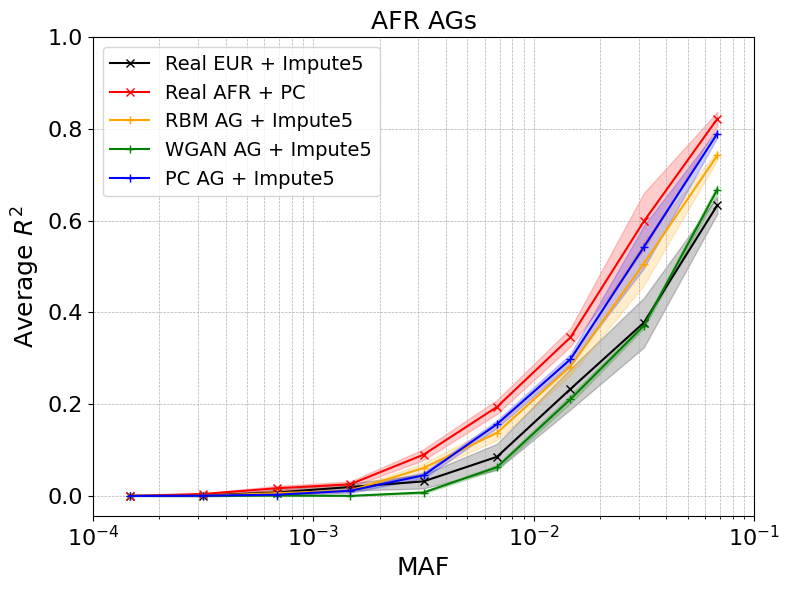

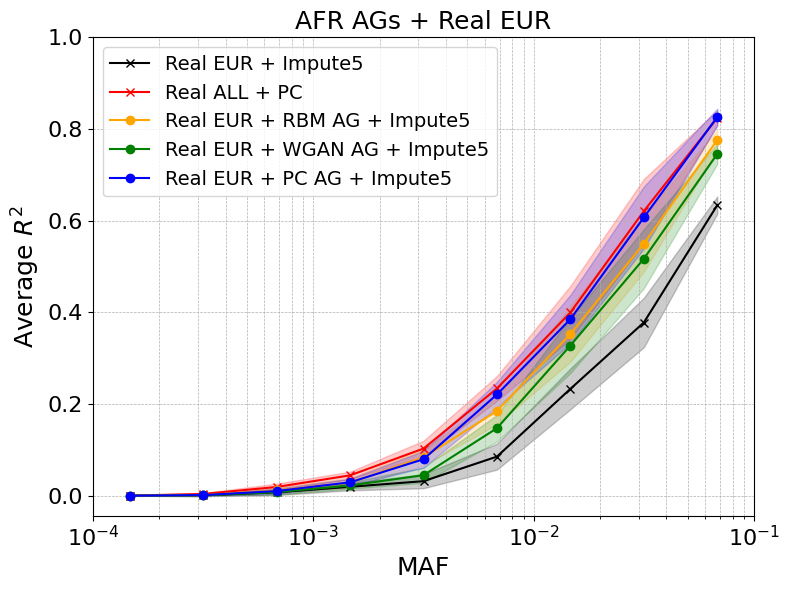

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the logarithmic bins
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Calculate bin centers for plotting

# Methods, colors, markers, and labels
all_methods = ['real_afr', 'pc_real_afr', 'pc_realeur_and_afr_train_afr', 'rbm_afr', 'wgan_afr', 'hclt_afr', 'rbm_afr_combined', 'wgan_afr_combined', 'hclt_afr_combined']
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = ['Real EUR + Impute5', 'Real AFR + PC', 'Real ALL + PC', 'RBM AG + Impute5', 'WGAN AG + Impute5', 'PC AG + Impute5',
              'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', 'Real EUR + PC AG + Impute5']
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

# Split indices for subplotting
baseline_indices = [0, 1, 3, 4, 5]  # RBM, WGAN, HCLT
combined_indices = [0, 2, 6, 7, 8]  # Real EUR + combinations

# Load data
method_data = {method: pd.read_csv(f'results/r2/{method}_afr.csv') for method in all_methods}

for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_afr.csv')

    # Get bootstrap columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Define MAF filters
    low_freq = df[df['MAF'] < 0.01]
    rare = df[df['MAF'] < 0.001]

    def summarize_bootstrap(subset_df, label):
        if subset_df.empty:
            print(f"  {label}: No data")
            return

        # Mean of each bootstrap (across SNPs in the filtered group)
        bootstrap_means = subset_df[boot_cols].mean(skipna=True)

        # Mean of the means
        overall_mean = bootstrap_means.mean()
        sem = bootstrap_means.std(ddof=1)
        ci_lower = overall_mean - 1.96 * sem
        ci_upper = overall_mean + 1.96 * sem

        print(f"  {label} Mean R²: {overall_mean:.4f}")
        print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

    print(f"Method: {method}")

    # Full set
    full_bootstrap_means = df[boot_cols].mean(skipna=True)
    full_mean = full_bootstrap_means.mean()
    full_sem = full_bootstrap_means.std(ddof=1)
    full_ci_lower = full_mean - 1.96 * full_sem
    full_ci_upper = full_mean + 1.96 * full_sem
    print(f"  Mean R²: {full_mean:.4f}")
    print(f"  95% CI: [{full_ci_lower:.4f}, {full_ci_upper:.4f}]")

    # Subsets
    summarize_bootstrap(low_freq, "Low-freq (<1%)")
    summarize_bootstrap(rare, "Rare (<0.1%)")

    method_data[method] = df

# --- Plot: AFR AGs ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in baseline_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle='-', color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('AFR AGs', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/afr_bootstrap_baseline.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# --- Plot: AFR AGs + Real EUR ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in combined_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]
    linestyle = all_linestyles[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('AFR AGs + Real EUR', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/afr_bootstrap_combined.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Method: UKBB_real_8020
  Mean R²: 0.9568
  95% CI: [0.9535, 0.9601]
  Low-freq (<1%) Mean R²: 0.9144
  Low-freq (<1%) 95% CI: [0.9072, 0.9217]
  Rare (<0.1%) Mean R²: 0.8178
  Rare (<0.1%) 95% CI: [0.7962, 0.8394]
Method: UKBB_pc_real_8020
  Mean R²: 0.9063
  95% CI: [0.9033, 0.9093]
  Low-freq (<1%) Mean R²: 0.8283
  Low-freq (<1%) 95% CI: [0.8218, 0.8347]
  Rare (<0.1%) Mean R²: 0.7085
  Rare (<0.1%) 95% CI: [0.6873, 0.7297]
Method: UKBB_rbm_8020
  Mean R²: 0.6685
  95% CI: [0.6668, 0.6703]
  Low-freq (<1%) Mean R²: 0.3806
  Low-freq (<1%) 95% CI: [0.3769, 0.3842]
  Rare (<0.1%) Mean R²: 0.1176
  Rare (<0.1%) 95% CI: [0.1117, 0.1234]
Method: UKBB_wgan_8020
  Mean R²: 0.5231
  95% CI: [0.5224, 0.5238]
  Low-freq (<1%) Mean R²: 0.0869
  Low-freq (<1%) 95% CI: [0.0862, 0.0876]
  Rare (<0.1%) Mean R²: 0.0002
  Rare (<0.1%) 95% CI: [0.0001, 0.0003]
Method: UKBB_hclt_8020
  Mean R²: 0.7499
  95% CI: [0.7484, 0.7514]
  Low-freq (<1%) Mean R²: 0.5250
  Low-freq (<1%) 95% CI: [0.5220, 0.5280]

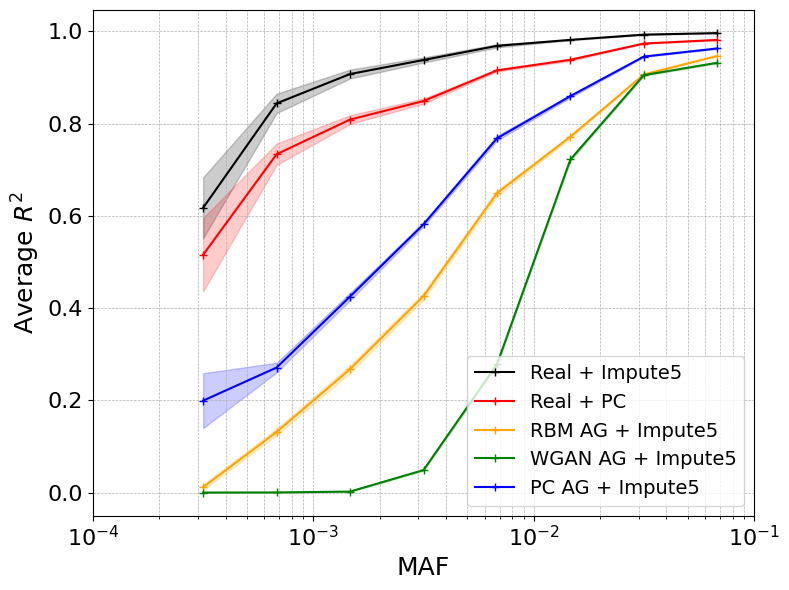

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the logarithmic bins
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Calculate bin centers for plotting

# Plot settings
plt.figure(figsize=(8, 6))

# Methods, colors, markers, labels, and linestyles
all_methods = ['UKBB_real_8020', 'UKBB_pc_real_8020', 'UKBB_rbm_8020', 'UKBB_wgan_8020', 'UKBB_hclt_8020']
all_colors = ['black', 'r', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+']
all_labels = [
    'Real + Impute5', 'Real + PC', 'RBM AG + Impute5', 'WGAN AG + Impute5', 'PC AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-']

# Load data
method_data = {method: pd.read_csv(f'results/r2/{method}_bootstraps.csv') for method in all_methods}

for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_bootstraps.csv')

    r2_cols = [col for col in df.columns if col.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)

    # Get bootstrap columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Define MAF filters
    low_freq = df[df['MAF'] < 0.01]
    rare = df[df['MAF'] < 0.001]

    def summarize_bootstrap(subset_df, label):
        if subset_df.empty:
            print(f"  {label}: No data")
            return

        # Mean of each bootstrap (across SNPs in the filtered group)
        bootstrap_means = subset_df[boot_cols].mean(skipna=True)

        # Mean of the means
        overall_mean = bootstrap_means.mean()
        sem = bootstrap_means.std(ddof=1)
        ci_lower = overall_mean - 1.96 * sem
        ci_upper = overall_mean + 1.96 * sem

        print(f"  {label} Mean R²: {overall_mean:.4f}")
        print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

    print(f"Method: {method}")

    # Full set
    full_bootstrap_means = df[boot_cols].mean(skipna=True)
    full_mean = full_bootstrap_means.mean()
    full_sem = full_bootstrap_means.std(ddof=1)
    full_ci_lower = full_mean - 1.96 * full_sem
    full_ci_upper = full_mean + 1.96 * full_sem
    print(f"  Mean R²: {full_mean:.4f}")
    print(f"  95% CI: [{full_ci_lower:.4f}, {full_ci_upper:.4f}]")

    # Subsets
    summarize_bootstrap(low_freq, "Low-freq (<1%)")
    summarize_bootstrap(rare, "Rare (<0.1%)")

    method_data[method] = df

# Plot each method with CI bands
for method_name, color, marker, label, linestyle in zip(all_methods, all_colors, all_markers, all_labels, all_linestyles):
    df = method_data[method_name]
    
    # Ensure MAF is valid
    df = df[df['MAF'] > 0]
    
    # Digitize MAFs into bins
    bin_indices = np.digitize(df['MAF'], bins) - 1

    # Get the list of bootstrap R2 columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Prepare containers
    mean_r2 = []
    ci_low = []
    ci_high = []

    # Compute stats for each bin
    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values  # shape: (n_snps, 10)
        bin_means = np.nanmean(boot_values, axis=0)     # mean for each bootstrap
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem  # 95% confidence interval

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    # Plot line and confidence interval
    plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

# Plot formatting
plt.xscale('log')
plt.xticks([1e-4, 1e-3, 1e-2, 1e-1],
           [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"],
           fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('MAF', fontsize=18)
plt.ylabel(r'Average $R^2$', fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("results/plots/UKBB_8020_bootstrap_ci.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()


Method: UKBB_real_noneur
  Mean R²: 0.7334
  95% CI: [0.7252, 0.7415]
  Low-freq (<1%) Mean R²: 0.5062
  Low-freq (<1%) 95% CI: [0.4908, 0.5217]
  Rare (<0.1%) Mean R²: 0.2110
  Rare (<0.1%) 95% CI: [0.1737, 0.2483]
Method: UKBB_pc_real_noneur
  Mean R²: 0.7494
  95% CI: [0.7422, 0.7566]
  Low-freq (<1%) Mean R²: 0.4977
  Low-freq (<1%) 95% CI: [0.4827, 0.5128]
  Rare (<0.1%) Mean R²: 0.1587
  Rare (<0.1%) 95% CI: [0.1274, 0.1899]
Method: UKBB_pc_realeur_and_noneur_train
  Mean R²: 0.7591
  95% CI: [0.7517, 0.7665]
  Low-freq (<1%) Mean R²: 0.5219
  Low-freq (<1%) 95% CI: [0.5067, 0.5371]
  Rare (<0.1%) Mean R²: 0.2103
  Rare (<0.1%) 95% CI: [0.1747, 0.2459]
Method: UKBB_rbm_noneur
  Mean R²: 0.4950
  95% CI: [0.4926, 0.4974]
  Low-freq (<1%) Mean R²: 0.1277
  Low-freq (<1%) 95% CI: [0.1232, 0.1322]
  Rare (<0.1%) Mean R²: 0.0041
  Rare (<0.1%) 95% CI: [0.0025, 0.0058]
Method: UKBB_wgan_noneur
  Mean R²: 0.4614
  95% CI: [0.4598, 0.4629]
  Low-freq (<1%) Mean R²: 0.0594
  Low-freq (<1%

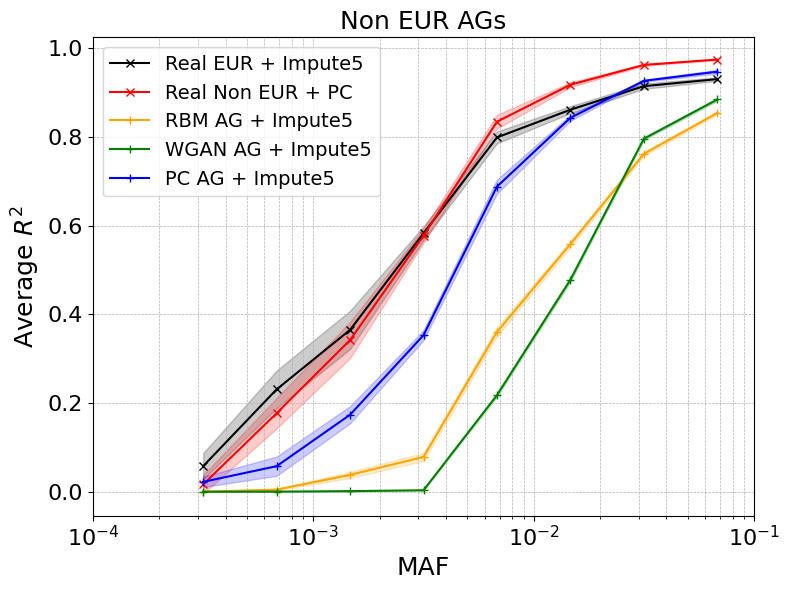

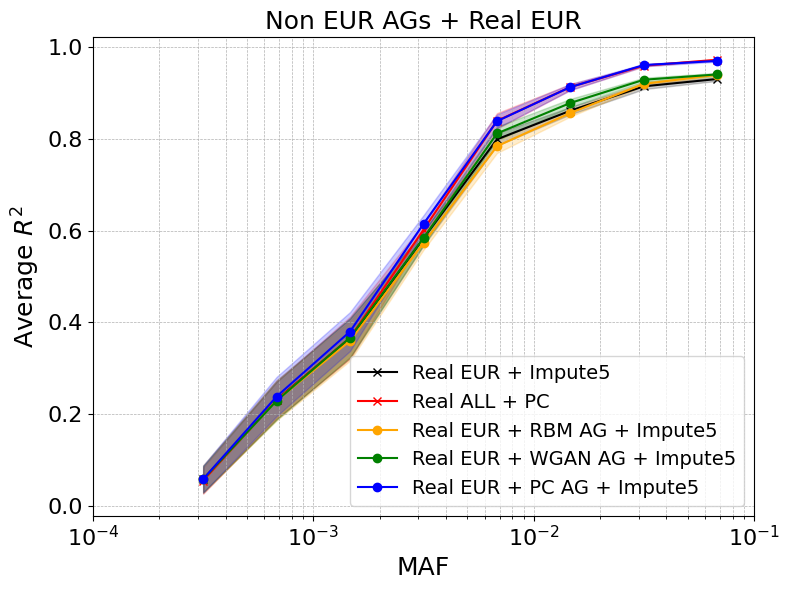

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the logarithmic bins
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Calculate bin centers for plotting

# Methods, colors, markers, and labels
all_methods = ['UKBB_real_noneur', 'UKBB_pc_real_noneur', 'UKBB_pc_realeur_and_noneur_train', 'UKBB_rbm_noneur', 'UKBB_wgan_noneur', 'UKBB_hclt_noneur', 'UKBB_rbm_noneur_combined', 'UKBB_wgan_noneur_combined', 'UKBB_hclt_noneur_combined']
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = ['Real EUR + Impute5', 'Real Non EUR + PC', 'Real ALL + PC', 'RBM AG + Impute5', 'WGAN AG + Impute5', 'PC AG + Impute5',
              'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', 'Real EUR + PC AG + Impute5']
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

# Split indices for subplotting
baseline_indices = [0, 1, 3, 4, 5]  # RBM, WGAN, HCLT
combined_indices = [0, 2, 6, 7, 8]  # Real EUR + combinations

# Load data
method_data = {method: pd.read_csv(f'results/r2/{method}_bootstraps.csv') for method in all_methods}

for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_bootstraps.csv')

    r2_cols = [col for col in df.columns if col.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
        
    # Get bootstrap columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Define MAF filters
    low_freq = df[df['MAF'] < 0.01]
    rare = df[df['MAF'] < 0.001]

    def summarize_bootstrap(subset_df, label):
        if subset_df.empty:
            print(f"  {label}: No data")
            return

        # Mean of each bootstrap (across SNPs in the filtered group)
        bootstrap_means = subset_df[boot_cols].mean(skipna=True)

        # Mean of the means
        overall_mean = bootstrap_means.mean()
        sem = bootstrap_means.std(ddof=1)
        ci_lower = overall_mean - 1.96 * sem
        ci_upper = overall_mean + 1.96 * sem

        print(f"  {label} Mean R²: {overall_mean:.4f}")
        print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

    print(f"Method: {method}")

    # Full set
    full_bootstrap_means = df[boot_cols].mean(skipna=True)
    full_mean = full_bootstrap_means.mean()
    full_sem = full_bootstrap_means.std(ddof=1)
    full_ci_lower = full_mean - 1.96 * full_sem
    full_ci_upper = full_mean + 1.96 * full_sem
    print(f"  Mean R²: {full_mean:.4f}")
    print(f"  95% CI: [{full_ci_lower:.4f}, {full_ci_upper:.4f}]")

    # Subsets
    summarize_bootstrap(low_freq, "Low-freq (<1%)")
    summarize_bootstrap(rare, "Rare (<0.1%)")

    method_data[method] = df

# --- Plot: Non EUR AGs ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in baseline_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]
    linestyle = all_linestyles[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('Non EUR AGs', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/UKBB_noneur_bootstrap_baseline.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# --- Plot: Non EUR AGs + Real EUR ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in combined_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle='-', color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('Non EUR AGs + Real EUR', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/UKBB_noneur_bootstrap_combined.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Method: UKBB_real_afr
  Mean R²: 0.6450
  95% CI: [0.6270, 0.6630]
  Low-freq (<1%) Mean R²: 0.3840
  Low-freq (<1%) 95% CI: [0.3539, 0.4140]
  Rare (<0.1%) Mean R²: 0.1150
  Rare (<0.1%) 95% CI: [0.0913, 0.1387]
Method: UKBB_pc_real_afr
  Mean R²: 0.6786
  95% CI: [0.6628, 0.6944]
  Low-freq (<1%) Mean R²: 0.3636
  Low-freq (<1%) 95% CI: [0.3374, 0.3899]
  Rare (<0.1%) Mean R²: 0.0642
  Rare (<0.1%) 95% CI: [0.0507, 0.0777]
Method: UKBB_pc_realeur_and_afr_train
  Mean R²: 0.6975
  95% CI: [0.6794, 0.7155]
  Low-freq (<1%) Mean R²: 0.4036
  Low-freq (<1%) 95% CI: [0.3730, 0.4342]
  Rare (<0.1%) Mean R²: 0.1107
  Rare (<0.1%) 95% CI: [0.0867, 0.1348]
Method: UKBB_rbm_afr
  Mean R²: 0.4369
  95% CI: [0.4277, 0.4461]
  Low-freq (<1%) Mean R²: 0.0608
  Low-freq (<1%) 95% CI: [0.0518, 0.0698]
  Rare (<0.1%) Mean R²: 0.0007
  Rare (<0.1%) 95% CI: [0.0002, 0.0011]
Method: UKBB_wgan_afr
  Mean R²: 0.3754
  95% CI: [0.3744, 0.3764]
  Low-freq (<1%) Mean R²: 0.0089
  Low-freq (<1%) 95% CI: [0.00

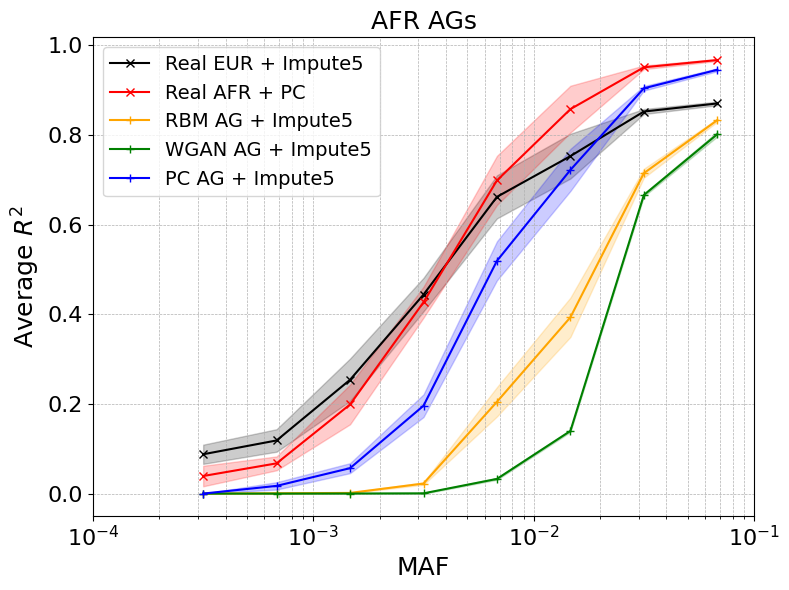

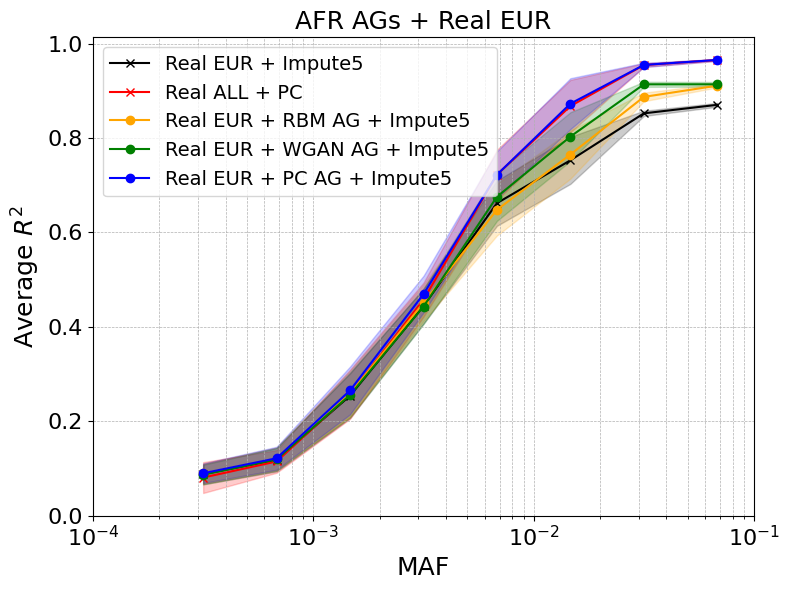

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the logarithmic bins
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Calculate bin centers for plotting

# Methods, colors, markers, and labels
all_methods = ['UKBB_real_afr', 'UKBB_pc_real_afr', 'UKBB_pc_realeur_and_afr_train', 'UKBB_rbm_afr', 'UKBB_wgan_afr', 'UKBB_hclt_afr', 'UKBB_rbm_afr_combined', 'UKBB_wgan_afr_combined', 'UKBB_hclt_afr_combined']
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = ['Real EUR + Impute5', 'Real AFR + PC', 'Real ALL + PC', 'RBM AG + Impute5', 'WGAN AG + Impute5', 'PC AG + Impute5',
              'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', 'Real EUR + PC AG + Impute5']
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

# Split indices for subplotting
baseline_indices = [0, 1, 3, 4, 5]  # RBM, WGAN, HCLT
combined_indices = [0, 2, 6, 7, 8]  # Real EUR + combinations

# Load data
method_data = {method: pd.read_csv(f'results/r2/{method}_bootstraps.csv') for method in all_methods}

for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_bootstraps.csv')

    r2_cols = [col for col in df.columns if col.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
        
    # Get bootstrap columns
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    # Define MAF filters
    low_freq = df[df['MAF'] < 0.01]
    rare = df[df['MAF'] < 0.001]

    def summarize_bootstrap(subset_df, label):
        if subset_df.empty:
            print(f"  {label}: No data")
            return

        # Mean of each bootstrap (across SNPs in the filtered group)
        bootstrap_means = subset_df[boot_cols].mean(skipna=True)

        # Mean of the means
        overall_mean = bootstrap_means.mean()
        sem = bootstrap_means.std(ddof=1)
        ci_lower = overall_mean - 1.96 * sem
        ci_upper = overall_mean + 1.96 * sem

        print(f"  {label} Mean R²: {overall_mean:.4f}")
        print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

    print(f"Method: {method}")

    # Full set
    full_bootstrap_means = df[boot_cols].mean(skipna=True)
    full_mean = full_bootstrap_means.mean()
    full_sem = full_bootstrap_means.std(ddof=1)
    full_ci_lower = full_mean - 1.96 * full_sem
    full_ci_upper = full_mean + 1.96 * full_sem
    print(f"  Mean R²: {full_mean:.4f}")
    print(f"  95% CI: [{full_ci_lower:.4f}, {full_ci_upper:.4f}]")

    # Subsets
    summarize_bootstrap(low_freq, "Low-freq (<1%)")
    summarize_bootstrap(rare, "Rare (<0.1%)")

    method_data[method] = df

# --- Plot: Non EUR AGs ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in baseline_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]
    linestyle = all_linestyles[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('AFR AGs', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/UKBB_afr_bootstrap_baseline.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# --- Plot: Non EUR AGs + Real EUR ---
fig, ax = plt.subplots(figsize=(8, 6))

for idx in combined_indices:
    method_name = all_methods[idx]
    color = all_colors[idx]
    marker = all_markers[idx]
    label = all_labels[idx]

    df = method_data[method_name]
    df = df[df['MAF'] > 0]
    bin_indices = np.digitize(df['MAF'], bins) - 1
    boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

    mean_r2, ci_low, ci_high = [], [], []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    ax.plot(bin_centers, mean_r2, marker=marker, linestyle='-', color=color, label=label)
    ax.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
ax.set_yticks(np.linspace(0, 1, 6))
ax.tick_params(axis='both', labelsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylabel(r'Average $R^2$', fontsize=18)
ax.set_xlabel('MAF', fontsize=18)
ax.set_title('AFR AGs + Real EUR', fontsize=18)
ax.legend(fontsize=14)

plt.tight_layout()
plt.savefig("results/plots/UKBB_afr_bootstrap_combined.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()